In [1]:
import matplotlib;matplotlib.rcParams['figure.figsize'] = (8,5)
import matplotlib;matplotlib.rcParams['text.usetex'] = True
import matplotlib;matplotlib.rcParams['font.size'] = 16
import matplotlib;matplotlib.rcParams['font.family'] = 'serif'
import GPy
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

# Gaussian Process Regression  

Analysis of [AIM-94 ICU Time Series dataset](https://archive.ics.uci.edu/ml/datasets/ICU)

Here is the description of the patient that was observed:  
  
8.5 month old female with biliary atresia, S/P (surgical procedure) 
Kasai procedure, ascending cholangitis with a history of
multiple liver abscesses and portal hypertension.  She was transferred to
The Children's Hospital after a 15 day history of E. Coli sepsis, worsening
despite antibiotic therapy and other supportive measures.  She currently is
in liver failure with coagulopathy.  She has required mechanical
ventilatory support due to the ARDS that followed the onset of sepsis.

Her admission body weight is 5 kg.

In addition to medications listed in data set, the patient receives:

Oral nystatin  
Ativan 0.5 mg IV every 6 hours  
Amphotericin bladder irrigation every 12 hours  
Nebulized ventolin PRN  
Maalox 10cc by nasogastric tube every 6 hours for gastric pH < 5  

In [2]:
icu_data = pd.read_csv('aim94_map_data_for_DSA.csv',header=0)

Now let's take a look at the patient time series. We'll focus our analysis on mean arterial pressure, the average pressure in a patient’s arteries during one cardiac cycle. The blue region from 35000 seconds up to the end of the time series will be set aside to test the predictions of our model.

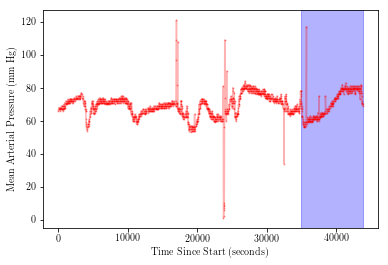

In [3]:
%matplotlib inline

end_of_series = np.max(icu_data.iloc[:,0].values)

plt.plot(icu_data.iloc[:,0].values,icu_data.iloc[:,1],'-o',color='r',alpha=0.3,markersize=1)
plt.xlabel('Time Since Start (seconds)')
plt.ylabel('Mean Arterial Pressure (mm Hg)')
plt.axvspan(35000,end_of_series,alpha=0.3,color='blue')

plt.show()

In [8]:
time_since_start = icu_data.iloc[:,0].values
map_values = icu_data.iloc[:,1].values

# we'll center the map values by substracting the mean
map_values = map_values - np.mean(map_values)

end_of_train = np.where(time_since_start >= 35000)[0][0]

train_X = np.expand_dims(time_since_start[:end_of_train],1)
train_Y = np.expand_dims(map_values[:end_of_train],1)
test_X = np.expand_dims(time_since_start[end_of_train:],1)
test_Y = np.expand_dims(map_values[end_of_train:],1)

Now we'll specify our kernel (with default hyperparameter values for now).

In [17]:
kernel = GPy.kern.RBF(input_dim=1, variance=1., lengthscale=10.)

In [18]:
m = GPy.models.GPRegression(train_X,train_Y,kernel)

GP_regression.,value,constraints,priors
rbf.variance,1.0,+ve,
rbf.lengthscale,10.0,+ve,
Gaussian_noise.variance,1.0,+ve,


{'dataplot': [<matplotlib.collections.PathCollection at 0x7fe3019d8e48>],
 'gpmean': [[<matplotlib.lines.Line2D at 0x7fe3019d87f0>]],
 'gpconfidence': [<matplotlib.collections.PolyCollection at 0x7fe303a7feb8>]}

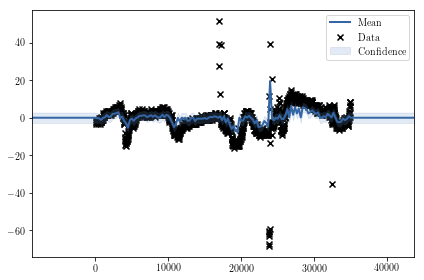

In [19]:
display(m)
m.plot()

In [44]:
m.optimize_restarts(num_restarts = 10)

Optimization restart 1/10, f = 3790.1195636969032
Optimization restart 2/10, f = 4499.0733929663065
Optimization restart 3/10, f = 4499.0733929661355
Optimization restart 4/10, f = 4499.073392966136
Optimization restart 5/10, f = 4499.073392966326
Optimization restart 6/10, f = 4499.073392966137
Optimization restart 7/10, f = 4499.073392966138
Optimization restart 8/10, f = 4499.073392966136
Optimization restart 9/10, f = 4499.073392966136
Optimization restart 10/10, f = 4499.073392966139


GP_regression.,value,constraints,priors
rbf.variance,41.37437032518087,+ve,
rbf.lengthscale,79.48834922723633,+ve,
Gaussian_noise.variance,10.396282985155807,+ve,


{'dataplot': [<matplotlib.collections.PathCollection at 0x7fe3010fe5f8>],
 'gpmean': [[<matplotlib.lines.Line2D at 0x7fe30116a438>]],
 'gpconfidence': [<matplotlib.collections.PolyCollection at 0x7fe30116a9b0>]}

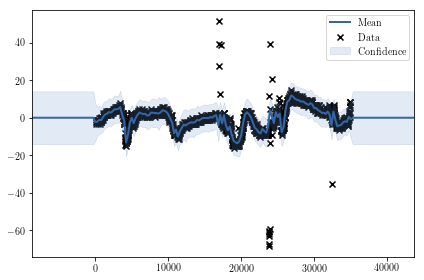

In [46]:
display(m)
m.plot()

Now let's see how well our model predicts the last roughly 10 minutes of the time series 

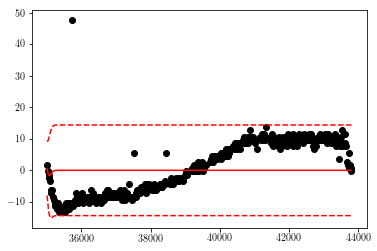

In [47]:
pred_Y,pred_Y_var = m.predict(test_X)

plt.plot(test_X,test_Y,'ok')
plt.plot(test_X,pred_Y,'-r')
plt.plot(test_X,pred_Y+2*pred_Y_var**0.5,'--r')
plt.plot(test_X,pred_Y-2*pred_Y_var**0.5,'--r')

plt.show()

# Gaussian Process Classification
Analysis of [UCI Chronic Kidney Disease dataset](https://archive.ics.uci.edu/ml/datasets/Chronic_Kidney_Disease)

In [2]:
ckd_data = pd.read_csv('chronic_kidney_disease_for_DSA_9.csv',header=0)
print(ckd_data.shape)
print(ckd_data.loc[ckd_data['class'] == 1].shape)
print(ckd_data.loc[ckd_data['class'] == 0].shape)

(400, 10)
(249, 10)
(151, 10)


For the sake of this tutorial, we'll only deal with 'complete' data (rows with no missing entries). Data missingness is a common issue (esp. in the healthcare domain).

In [3]:
missing_row_idx = pd.Series.any(pd.isna(ckd_data),1)
ckd_data_no_missing = ckd_data.iloc[np.where(missing_row_idx.values.flatten() != True)[0],:]

There are 9 feature columns and 1 label column.

The feature columns are as follows:
  
| **Feature**  | **Description**  |  
|---|---|  
| age  | Age of patient  |  
| bp  | Blood pressure  |  
| bgr  | Blood glucose (random) |  
| bu | Blood urea |  
| sc | Serum creatinine |  
| hemo | Hemoglobin |  
| pcv | Packed cell volume |  
| wbcc | White blood cell count |  
| rbcc | Red blood cell count |  
    
The label column is called 'class' and takes values '1' (for the presence of chronic kidney disease) or '0' (for its absence).

In [46]:
print(ckd_data_no_missing.shape)
print(ckd_data_no_missing.loc[ckd_data_no_missing['class'] == 1].shape)
print(ckd_data_no_missing.loc[ckd_data_no_missing['class'] == 0].shape)

(237, 10)
(106, 10)
(131, 10)


Now, we'll standardize the feature columns.

In [10]:
ckd_features = ckd_data_no_missing.iloc[:,0:9]
ckd_features = (ckd_features - ckd_features.mean())/ckd_features.std()
print(ckd_features.mean())
print(ckd_features.std())
ckd_features = ckd_features.values

age     2.314136e-16
bp     -8.265774e-16
bgr     3.864700e-18
bu     -1.311656e-17
sc      7.940203e-17
hemo   -1.822265e-16
pcv    -5.733810e-16
wbcc   -2.103334e-16
rbcc   -1.395977e-16
dtype: float64
age     1.0
bp      1.0
bgr     1.0
bu      1.0
sc      1.0
hemo    1.0
pcv     1.0
wbcc    1.0
rbcc    1.0
dtype: float64


In [45]:
ckd_labels = ckd_data_no_missing.iloc[:,9].values
ckd_labels = np.expand_dims(ckd_labels,2)

Now we'll randomly select a subset of the data to set aside as a test set

In [27]:
n_samps = ckd_features.shape[0]
test_idx = np.random.choice(range(n_samps),size=int(np.round(n_samps/5.)),replace=False)
train_idx = [x for x in range(n_samps) if not x in test_idx]

train_X = ckd_features[train_idx,:]
train_Y = ckd_labels[train_idx,:]
test_X = ckd_features[test_idx,:]
test_Y = ckd_labels[test_idx,:]

[Serum creatinine](https://www.mayoclinic.org/tests-procedures/creatinine-test/about/pac-20384646) is a useful laboratory marker of kidney function and is one of the features of our dataset. Let's see how a GP classification model based solely on serum creatinine compares to one based on all features.

In [37]:
train_X_crea = np.expand_dims(train_X[:,4],2)
test_X_crea = np.expand_dims(test_X[:,4],2)

kern = GPy.kern.RBF(1,variance=1.,lengthscale=1.)
lik = GPy.likelihoods.Bernoulli()
m_crea = GPy.core.GP(X=train_X_crea,
                Y=train_Y,
                kernel=kern,
                inference_method=GPy.inference.latent_function_inference.expectation_propagation.EP(),
                likelihood=lik)
print(m_crea)


Name : gp
Objective : 67.26272774750079
Number of Parameters : 2
Number of Optimization Parameters : 2
Updates : True
Parameters:
  gp.              |  value  |  constraints  |  priors
  rbf.variance     |    1.0  |      +ve      |        
  rbf.lengthscale  |    1.0  |      +ve      |        


In [42]:
m_crea = GPy.models.GPClassification(train_X_crea,train_Y)

In [43]:
m_crea.optimize(messages=1)

In [44]:
pred_probs_crea = m_crea.predict(test_X_crea)[0]
GPy.util.classification.conf_matrix(pred_probs_crea,test_Y)

91.48936170212767 % instances correctly classified
          |  1         |  0         | 
----------|------------|------------|
1         |  16.0      |  4         | 
0         |  0         |  27.0      | 


(0.0851063829787234, 16.0, 0, 27.0, 4)

In [41]:
kern = GPy.kern.RBF(train_X.shape[1], variance=1.,lengthscale=1.)
lik = GPy.likelihoods.Bernoulli()
m_all = GPy.core.GP(X=train_X,
                Y=train_Y,
                kernel=kern,
                inference_method=GPy.inference.latent_function_inference.expectation_propagation.EP(),
                likelihood=lik)
print(m_all)


Name : gp
Objective : 77.62777268808978
Number of Parameters : 2
Number of Optimization Parameters : 2
Updates : True
Parameters:
  gp.              |  value  |  constraints  |  priors
  rbf.variance     |    1.0  |      +ve      |        
  rbf.lengthscale  |    1.0  |      +ve      |        


In [32]:
m_all = GPy.models.GPClassification(train_X,train_Y)

In [33]:
m_all.optimize(messages=1)

In [34]:
pred_probs = m.predict(test_X)[0]
GPy.util.classification.conf_matrix(pred_probs, test_Y)

97.87234042553192 % instances correctly classified
          |  1         |  0         | 
----------|------------|------------|
1         |  19.0      |  1         | 
0         |  0         |  27.0      | 


(0.02127659574468085, 19.0, 0, 27.0, 1)